In [1]:
%load_ext autoreload

In [68]:
%autoreload 2
import h5py
from hydra import initialize, compose
import matplotlib.pyplot as plt
import os
import pandas as pd
import sys
import torch

sys.path.append('/home/eisenaj/code/UniversalUnconsciousness')
from hdf5_utils import *

sys.path.append('/home/eisenaj/code/CommunicationJacobians')
from CommunicationJacobians.jacobians.data_utils import compute_lyaps, estimate_weighted_jacobians


In [65]:
with initialize(version_base="1.3", config_path="../../DeLASE_analysis/conf"):
    cfg = compose(config_name="config")

In [51]:
# all_data_dir = '/orcd/data/ekmiller/001/common/datasets'
# data_class = 'propofolPuffTone'
data_class = 'anesthesiaLvrOdd'

In [52]:
# propofol dir
if data_class == 'propofolPuffTone':
    data_dir = os.path.join(cfg.params.all_data_dir, 'anesthesia', 'mat', data_class)
else:
    data_dir = os.path.join(cfg.params.all_data_dir, data_class, 'mat')


In [118]:
# session = "Mary-Anesthesia-20160912-02"
# session = "SPOCK_Ketamine_20210827"
# session = "SPOCK_Ketamine_20210902"
session = "SPOCK_Ketamine_20210712"

In [119]:
noise_filter_info = {}
if cfg.params.noise_filter:
    os.makedirs(cfg.params.noise_filter_results_dir, exist_ok=True)
    noise_filter_dir = os.path.join(cfg.params.noise_filter_results_dir, cfg.params.data_class)
    os.makedirs(noise_filter_dir, exist_ok=True)
    noise_filter_file = f"{session}__window_{cfg.params.window}__wakethresh_{cfg.params.wake_amplitude_thresh}__anesthesiathresh_{cfg.params.anesthesia_amplitude_thresh}__electrodenum_{cfg.params.electrode_num_thresh}.pkl"
    
    print("--------------------")
    print(f"Session: {session}")
    print("--------------------")
    if noise_filter_file in os.listdir(noise_filter_dir):
        noise_filter_info[session] = pd.read_pickle(os.path.join(noise_filter_dir, noise_filter_file))
    else:
        print("Finding noisy data...")
        window_df, bad_electrodes, valid_window_starts = find_noisy_data(cfg, session)
        noise_filter_info[session] = dict(
            window_df=window_df,
            bad_electrodes=bad_electrodes,
            valid_window_starts=valid_window_starts
        )
        pd.to_pickle(noise_filter_info[session], os.path.join(noise_filter_dir, noise_filter_file))
    
    print(f"{len(noise_filter_info[session]['bad_electrodes'])} bad electrodes, {len(noise_filter_info[session]['valid_window_starts'])} valid windows (out of {len(noise_filter_info[session]['window_df'])} total windows)")
else:
    bad_electrodes = []
    valid_window_starts = None
    noise_filter_info = dict(
        window_df=None,
        bad_electrodes=bad_electrodes,
        valid_window_starts=valid_window_starts
    )

--------------------
Session: SPOCK_Ketamine_20210712
--------------------
28 bad electrodes, 1068 valid windows (out of 1513 total windows)


In [120]:
session_file = h5py.File(os.path.join(data_dir,f"{session}.mat"), 'r')

In [121]:
lfp = TransposedDatasetView(session_file['lfp']).transpose()
dt = session_file['lfpSchema']['smpInterval'][0, 0]
if data_class == 'propofolPuffTone':
    infusion_start = session_file['sessionInfo']['drugStart'][0, 0]
else:
    infusion_start = session_file['sessionInfo']['infusionStart'][0, 0]


In [122]:
wake_t = (infusion_start - 10*60)
anesthesia_t = (infusion_start + 20*60)

In [123]:
wake_window_start = noise_filter_info[session]['valid_window_starts'][np.argmin(np.abs(wake_t - noise_filter_info[session]['valid_window_starts']))]
anesthesia_window_start = noise_filter_info[session]['valid_window_starts'][np.argmin(np.abs(anesthesia_t - noise_filter_info[session]['valid_window_starts']))]


In [124]:
bad_electrodes = noise_filter_info[session]['bad_electrodes']
valid_electrodes = [i for i in range(lfp.shape[1]) if i not in bad_electrodes]

In [125]:
lfp_w = lfp[int(wake_window_start/dt):int((wake_window_start + 5)/dt), valid_electrodes]
lfp_a = lfp[int(anesthesia_window_start/dt):int((anesthesia_window_start + 5)/dt), valid_electrodes]

In [126]:
jacs_pred_w, losses = estimate_weighted_jacobians(torch.from_numpy(lfp_w).to(device='cuda'), device='cuda', sweep=True, return_losses=True, verbose=True)
jacs_pred_w = (jacs_pred_w - torch.eye(jacs_pred_w.shape[-1]).type(jacs_pred_w.dtype).to(jacs_pred_w.device))/dt

jacs_pred_a, losses = estimate_weighted_jacobians(torch.from_numpy(lfp_a).to(device='cuda'), device='cuda', sweep=True, return_losses=True, verbose=True)
jacs_pred_a = (jacs_pred_a - torch.eye(jacs_pred_a.shape[-1]).type(jacs_pred_a.dtype).to(jacs_pred_a.device))/dt

Computing Weighted Jacobians:   0%|          | 0/55000 [00:00<?, ?it/s]

Computing Weighted Jacobians:   0%|          | 0/5000 [00:00<?, ?it/s]

Computing Weighted Jacobians:   0%|          | 0/55000 [00:00<?, ?it/s]

Computing Weighted Jacobians:   0%|          | 0/5000 [00:00<?, ?it/s]

In [116]:
lyaps_w = compute_lyaps(torch.matrix_exp(jacs_pred_w*dt), dt=dt, verbose=True, k=10)
lyaps_a = compute_lyaps(torch.matrix_exp(jacs_pred_a*dt), dt=dt, verbose=True, k=10)



  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

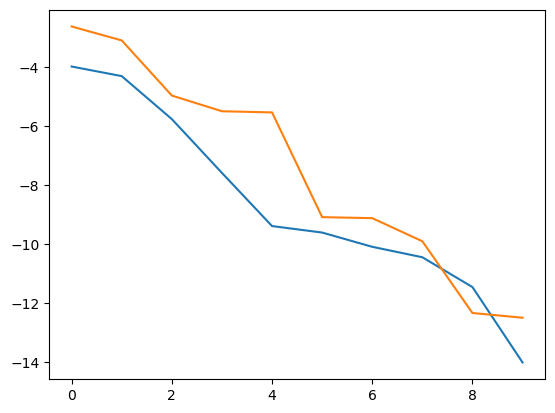

In [117]:
plt.plot(lyaps_w.cpu().numpy())
plt.plot(lyaps_a.cpu().numpy())
plt.show()